# Importing necessary Libraries

In [5]:
import os
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt


## Functions for fourier transform and inverse fourier transform

In [6]:
def fourier_transform(image):
    """
    Perform a Fourier transform on each color channel of an image.

    Parameters:
    image (numpy.ndarray): A 3D numpy array where the first two dimensions represent
                           the spatial dimensions (height and width) and the third
                           dimension represents the color channels (RGB).

    Returns:
    numpy.ndarray: A complex-valued array of the same shape as the input, representing
                   the Fourier-transformed image, with each color channel processed
                   separately.
    """
    # Initialize a complex array of zeros with the same shape as the input image
    dft = np.zeros_like(image, dtype=np.complex128)

    # Process each color channel individually
    for channel_index in range(3):  # Loop over the three color channels (RGB)
        # Apply the 2D Fourier Transform to the current channel
        dft[:, :, channel_index] = np.fft.fft2(image[:, :, channel_index])
        # Shift the zero-frequency component to the center of the spectrum
        dft[:, :, channel_index] = np.fft.fftshift(dft[:, :, channel_index])

    return dft

def inverse_fourier_transform(dft):
    """
    Perform an inverse Fourier transform on each color channel of a Fourier-transformed image.

    Parameters:
    dft (numpy.ndarray): A 3D numpy array of complex numbers representing the Fourier-transformed
                         image, with each color channel processed separately.

    Returns:
    numpy.ndarray: A real-valued array representing the inverse-transformed image, where the
                   real part of the complex result is taken, discarding any imaginary part.
    """
    # Initialize a complex array of zeros with the same shape as the input Fourier data
    image = np.zeros_like(dft, dtype=np.complex128)

    # Process each color channel individually
    for channel_index in range(3):  # Loop over the three color channels (RGB)
        # Shift the zero-frequency component back to the original location
        dft[:, :, channel_index] = np.fft.ifftshift(dft[:, :, channel_index])
        # Apply the 2D Inverse Fourier Transform to the current channel
        image[:, :, channel_index] = np.fft.ifft2(dft[:, :, channel_index])

    # Return the absolute value of the complex result to get the real part
    return np.abs(image)


## Functions for filters (gaussian, band_pass, notch, high_pass, low_pass)

In [7]:
def apply_filter(dft, filter_type='gaussian', filter_params=None):
    """
    Apply a spatial filter to the Fourier-transformed image data.

    Parameters:
    dft (numpy.ndarray): A 3D numpy array where the first two dimensions represent
                         the spatial dimensions (height and width) and the third
                         dimension represents the color channels (RGB) of the Fourier-transformed image.
    filter_type (str): Type of the filter to apply. Supported values are 'gaussian', 'band_pass',
                       'notch', 'high_pass', and 'low_pass'.
    filter_params (tuple or int): Parameters specific to the type of filter being used. This can
                                  be a single value or a tuple of values depending on the filter.

    Returns:
    numpy.ndarray: The Fourier-transformed image data after the filter has been applied to each color channel.
    """
    # Extract the number of rows and columns from the dft image dimensions
    rows, cols = dft.shape[:2]
    # Calculate the center of the image to use as the origin for filters
    crow, ccol = rows // 2, cols // 2

    # Initialize the filter mask with ones (no effect by default)
    filter_mask = np.ones((rows, cols), dtype=np.float32)

    # Conditional processing depending on the filter_type
    if filter_type == 'gaussian':
        # Gaussian filter: Applies a bell-shaped curve as the filter
        sigma = filter_params if filter_params else 10  # Default standard deviation
        x = np.linspace(-ccol, ccol, cols)
        y = np.linspace(-crow, crow, rows)
        x, y = np.meshgrid(x, y)  # Create a grid of (x,y) coordinates
        # Calculate the Gaussian function
        filter_mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    elif filter_type == 'band_pass':
        # Band-pass filter: Allows frequencies within a certain range
        low_cutoff, high_cutoff = filter_params if filter_params else (10, 20)
        mask1 = np.zeros((rows, cols), dtype=np.uint8)
        mask2 = np.zeros((rows, cols), dtype=np.uint8)
        # Create two circular masks: one with the high cutoff and one with the low cutoff
        cv2.circle(mask1, (ccol, crow), high_cutoff, 1, -1)
        cv2.circle(mask2, (ccol, crow), low_cutoff, 1, -1)
        filter_mask = mask1 - mask2  # Combine masks to create a band

    elif filter_type == 'notch':
        # Notch filter: Blocks a small area around the center
        notch_radius = filter_params if filter_params else 10
        cv2.circle(filter_mask, (ccol, crow), notch_radius, 0, -1)

    elif filter_type == 'high_pass':
        # High-pass filter: Blocks low frequencies
        cutoff = filter_params if filter_params else 30
        cv2.circle(filter_mask, (ccol, crow), cutoff, 0, -1)

    elif filter_type == 'low_pass':
        # Low-pass filter: Allows low frequencies
        cutoff = filter_params if filter_params else 30
        cv2.circle(filter_mask, (ccol, crow), cutoff, 1, -1)

    # Apply the filter mask to each channel of the Fourier-transformed image
    filtered_dft = np.empty_like(dft)
    for channel_index in range(3):  # Loop over the three color channels (RGB)
        # Multiply the DFT of each channel by the filter mask
        filtered_dft[:, :, channel_index] = dft[:, :, channel_index] * filter_mask

    return filtered_dft


## function for calaculating error metrics (PSNR, SSIM)

In [8]:
def calculate_metrics(gt_image, denoised_image):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index (SSIM)
    between the ground truth image and the denoised image for each color channel, and
    return their average values.

    Parameters:
    gt_image (numpy.ndarray): A 3D numpy array representing the ground truth image.
                              The array shape should be (height, width, channels),
                              where 'channels' typically represents the RGB channels.
    denoised_image (numpy.ndarray): A 3D numpy array of the same shape as gt_image,
                                    representing the image after denoising has been applied.

    Returns:
    tuple: A tuple containing two float values:
           - The average PSNR value across all color channels.
           - The average SSIM value across all color channels.
    """
    # Initialize lists to hold the PSNR and SSIM values for each channel
    psnr = []
    ssim = []

    # Loop through each color channel (typically RGB, hence range(3))
    for channel_index in range(3):
        # Calculate PSNR for the current channel
        psnr.append(compare_psnr(gt_image[:, :, channel_index], denoised_image[:, :, channel_index], data_range=255))
        # Calculate SSIM for the current channel
        ssim.append(compare_ssim(gt_image[:, :, channel_index], denoised_image[:, :, channel_index],
                                 multichannel=False, data_range=255))

    # Calculate and return the average PSNR and SSIM across all channels
    return np.mean(psnr), np.mean(ssim)


## Applying denoising techniques for SIDD dataset

In [9]:
# Directory where the image data is stored
data_directory = "SIDD_Small_sRGB_Only/Data"
# List directories within the data directory
folders = [f for f in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, f))]

# Dictionary to store PSNR and SSIM values for each filter type
all_psnr = {f: [] for f in ['gaussian', 'band_pass', 'notch', 'high_pass', 'low_pass']}
all_ssim = {f: [] for f in ['gaussian', 'band_pass', 'notch', 'high_pass', 'low_pass']}

# Ensure an output directory exists to save the processed images
output_dir = os.path.join(data_directory, 'outputs')
os.makedirs(output_dir, exist_ok=True)

# Process each folder containing images
for count, folder in enumerate(folders, start=1):
    # Create a unique subfolder for each image set in the output directory
    folder_output_dir = os.path.join(output_dir, folder)
    os.makedirs(folder_output_dir, exist_ok=True)

    # Construct the path to the ground truth and noisy images
    gt_path = os.path.join(data_directory, folder, "GT_SRGB_010.PNG")
    noisy_path = os.path.join(data_directory, folder, "NOISY_SRGB_010.PNG")

    # Load images
    gt_image = cv2.imread(gt_path)
    noisy_image = cv2.imread(noisy_path)

    # Check if images are loaded correctly
    if gt_image is None or noisy_image is None:
        print(f"Failed to load images for folder {folder}")
        continue

    # Apply Fourier transform to the noisy image
    dft_noisy = fourier_transform(noisy_image)
    filters = ['gaussian', 'band_pass', 'notch', 'high_pass', 'low_pass']

    # Apply different filters to the Fourier-transformed image
    for filter_type in filters:
        # Apply the specified filter and inverse transform
        filtered_dft = apply_filter(dft_noisy, filter_type=filter_type)
        denoised_image = inverse_fourier_transform(filtered_dft)
        denoised_image = np.clip(denoised_image, 0, 255).astype('uint8')
        
        # Calculate image quality metrics
        psnr, ssim = calculate_metrics(gt_image, denoised_image)
        all_psnr[filter_type].append(psnr)
        all_ssim[filter_type].append(ssim)

        # Construct the save path for the denoised image within its specific subfolder
        save_path = os.path.join(folder_output_dir, f"{filter_type}.png")
        # Save the image to disk
        cv2.imwrite(save_path, denoised_image)

    # Print progress
    print(f"Processed folder {count}/{len(folders)}")

# Calculate and print the average PSNR and SSIM across all processed sets
average_psnr = {f: np.mean(psnrs) for f, psnrs in all_psnr.items()}
average_ssim = {f: np.mean(ssims) for f, ssims in all_ssim.items()}
print("Average PSNR by filter type:", average_psnr)
print("Average SSIM by filter type:", average_ssim)


Processed folder 1/157
Processed folder 2/157
Processed folder 3/157
Processed folder 4/157
Processed folder 5/157
Processed folder 6/157
Processed folder 7/157
Processed folder 8/157
Processed folder 9/157
Processed folder 10/157
Processed folder 11/157
Processed folder 12/157
Processed folder 13/157
Processed folder 14/157
Processed folder 15/157
Processed folder 16/157
Processed folder 17/157
Processed folder 18/157
Processed folder 19/157
Processed folder 20/157
Processed folder 21/157
Processed folder 22/157
Processed folder 23/157
Processed folder 24/157
Processed folder 25/157
Processed folder 26/157
Processed folder 27/157
Processed folder 28/157
Processed folder 29/157
Processed folder 30/157
Processed folder 31/157
Processed folder 32/157
Processed folder 33/157
Processed folder 34/157
Processed folder 35/157
Processed folder 36/157
Processed folder 37/157
Processed folder 38/157
Processed folder 39/157
Processed folder 40/157
Processed folder 41/157
Processed folder 42/157
P

# Error  metric values for our SIDD Dataset

In [10]:
#below are the average error metric values useful for comparing with state of the art model
print("Average PSNR by filter type:", average_psnr)
print("Average SSIM by filter type:", average_ssim)

Average PSNR by filter type: {'gaussian': 25.4461264670742, 'band_pass': 12.414347737061346, 'notch': 13.684539568421485, 'high_pass': 13.329214301279048, 'low_pass': 27.90504535355441}
Average SSIM by filter type: {'gaussian': 0.8113184819874081, 'band_pass': 0.19176751074495732, 'notch': 0.21679958926381812, 'high_pass': 0.20403512342478375, 'low_pass': 0.5071823383327965}


In [11]:
## all psnr metric values for SIDD Dataset
all_psnr


{'gaussian': [25.35983952422826,
  20.836134495825302,
  19.06505896685178,
  27.4328196606965,
  20.278554014337374,
  19.798608667175063,
  24.997804203615242,
  19.99779135866091,
  24.130301450156097,
  19.085796301385717,
  23.74445225692482,
  19.18655875879386,
  21.103379880041683,
  29.505232311619178,
  27.079207224252503,
  19.692705483975143,
  22.933522627314478,
  21.88646776627924,
  26.218229426140237,
  25.120851415120786,
  29.630984375660375,
  27.667945154122847,
  21.59822031778013,
  26.05848497222696,
  28.45188799553972,
  19.310510650357628,
  18.693509426677224,
  18.99947577912315,
  26.591582916341178,
  23.909481613586745,
  30.953381939511022,
  26.38155298369823,
  23.798154864166126,
  18.46053681760758,
  25.848621492204575,
  27.23647263618562,
  26.94167928771597,
  25.9431133571766,
  18.01243601961326,
  18.057530288095652,
  23.898673178027806,
  23.286160324005788,
  28.91037388580794,
  28.97762142638584,
  26.67984058315462,
  24.91814392218629,

In [12]:
## all ssim metric values for SIDD Dataset
all_ssim

{'gaussian': [0.9142845205977882,
  0.8654328099461172,
  0.9055311196711565,
  0.9243987031906675,
  0.8757210222476495,
  0.8660047962228932,
  0.9017807012802739,
  0.8604886043820813,
  0.7528717891475637,
  0.82436997795686,
  0.8447384572999314,
  0.8226287903976842,
  0.853525665881011,
  0.9181071668980954,
  0.8965586187661237,
  0.7980439961966721,
  0.9032569586005615,
  0.8878144966774631,
  0.9237284697162352,
  0.8989607690485721,
  0.9257340660993222,
  0.9259336576138187,
  0.8381428802476911,
  0.9002173007498603,
  0.9135519887738194,
  0.7653124910700194,
  0.7251662386394252,
  0.6668427953089097,
  0.8564818849463641,
  0.8379544362402531,
  0.8825866567392534,
  0.8585497804036833,
  0.8338777909871347,
  0.7450731198336578,
  0.8971048038012922,
  0.8725453178096774,
  0.8974778591043396,
  0.648952160410262,
  0.7887537881797821,
  0.7615067561884881,
  0.8618531040997013,
  0.8502679520623128,
  0.8974867638567156,
  0.8833805541063183,
  0.8799448022698683,
  

## Visualisations of Error metrics of SIDD Dataset

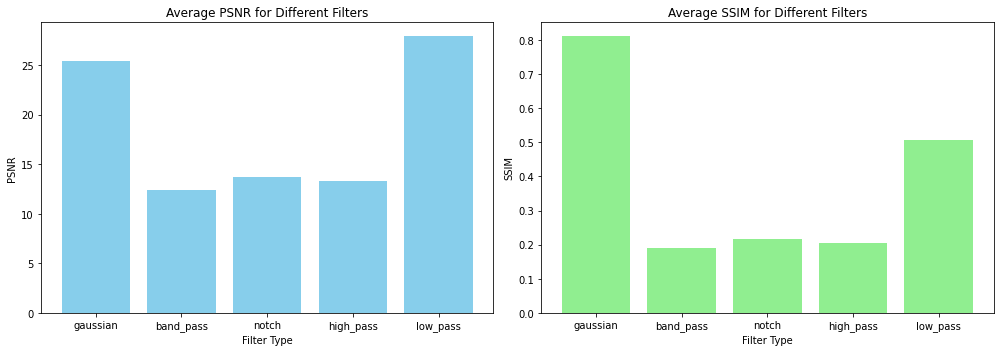

In [13]:
# Calculate the average of the metrics for each filter type
# This uses numpy to compute the mean of PSNR and SSIM values collected during processing.
average_psnr = {filter_type: np.mean(values) for filter_type, values in all_psnr.items()}
average_ssim = {filter_type: np.mean(values) for filter_type, values in all_ssim.items()}

# Create bar charts using matplotlib to visualize the average PSNR and SSIM for different filters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for PSNR
# Here, each bar represents the average PSNR for a specific filter type.
ax1.bar(average_psnr.keys(), average_psnr.values(), color='skyblue')
ax1.set_title('Average PSNR for Different Filters')  # Title for the PSNR subplot
ax1.set_ylabel('PSNR')  # Y-axis label for PSNR values
ax1.set_xlabel('Filter Type')  # X-axis label indicating the filter types

# Bar chart for SSIM
# Similarly, each bar represents the average SSIM for a specific filter type.
ax2.bar(average_ssim.keys(), average_ssim.values(), color='lightgreen')
ax2.set_title('Average SSIM for Different Filters')  # Title for the SSIM subplot
ax2.set_ylabel('SSIM')  # Y-axis label for SSIM values
ax2.set_xlabel('Filter Type')  # X-axis label indicating the filter types

# Adjust layout to prevent overlapping of elements
plt.tight_layout()
# Display the plots
plt.show()
